In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
# 날짜 데이터 수정
train['date']=train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms']


<AxesSubplot:>

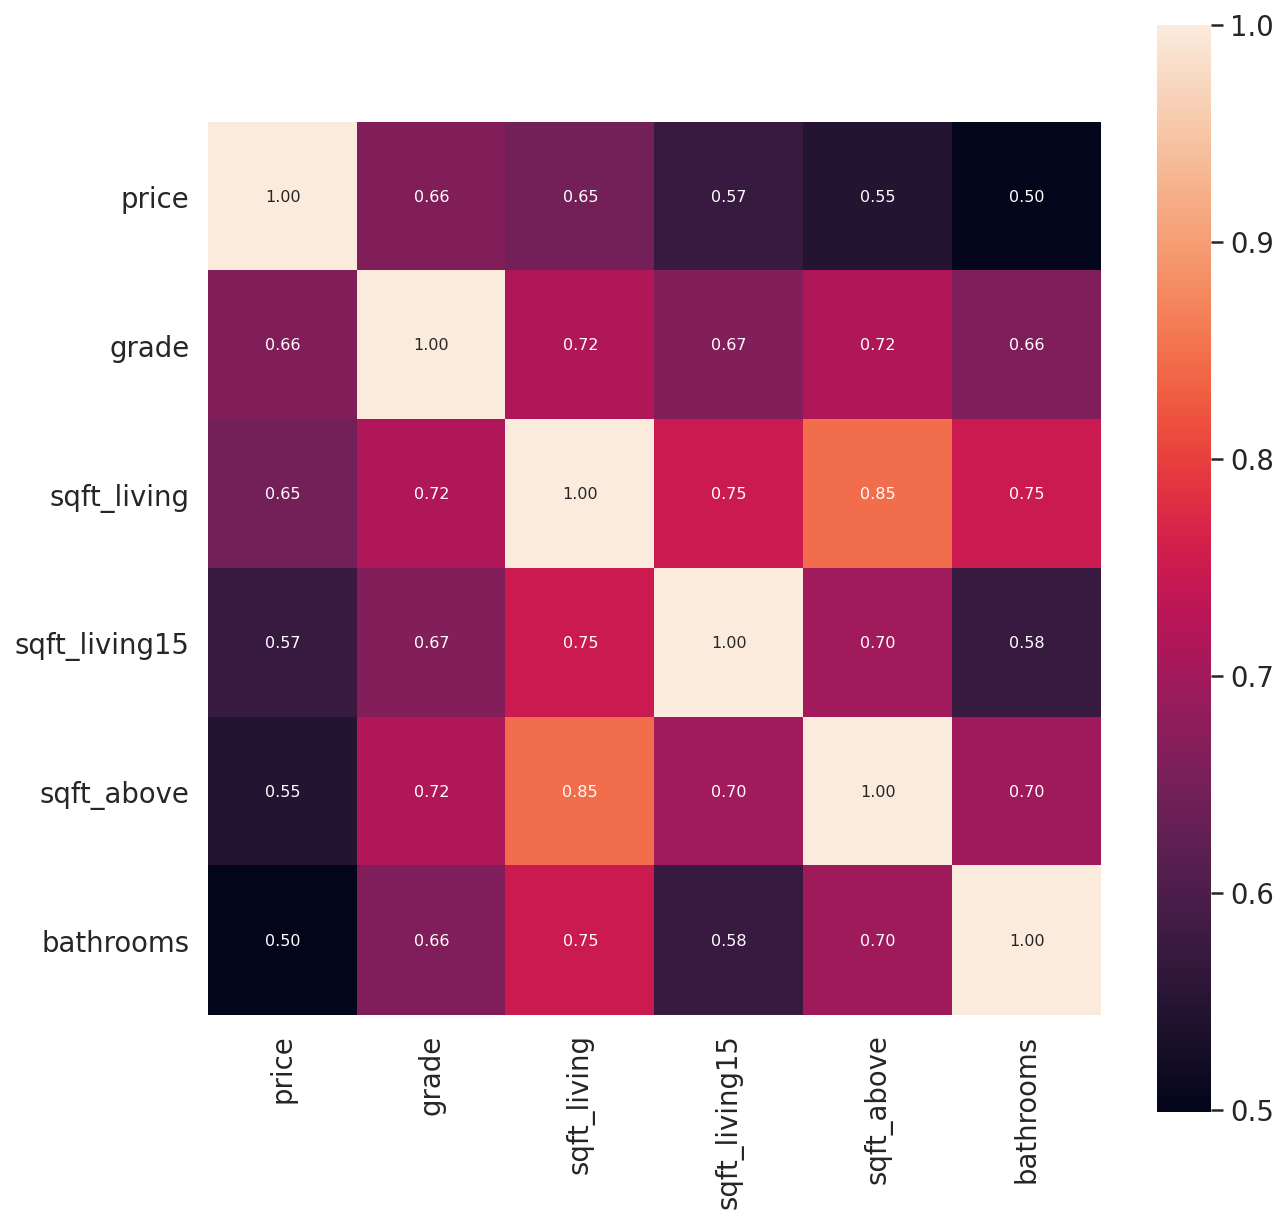

In [6]:
import scipy as sp
cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=6, columns="price").index 
# spearman coefficient matrix
cor = sp.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

price와 연관이 높은 5개의 변수는 grade, sqft_living, sqft_living15, sqft_above, bathrooms이다

In [7]:
# 가격 정보 y에 저장하고 price 항목 삭제
y=train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [9]:
test['date']=test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


# 2. 전처리 하기
## 결측치 확인

<AxesSubplot:>

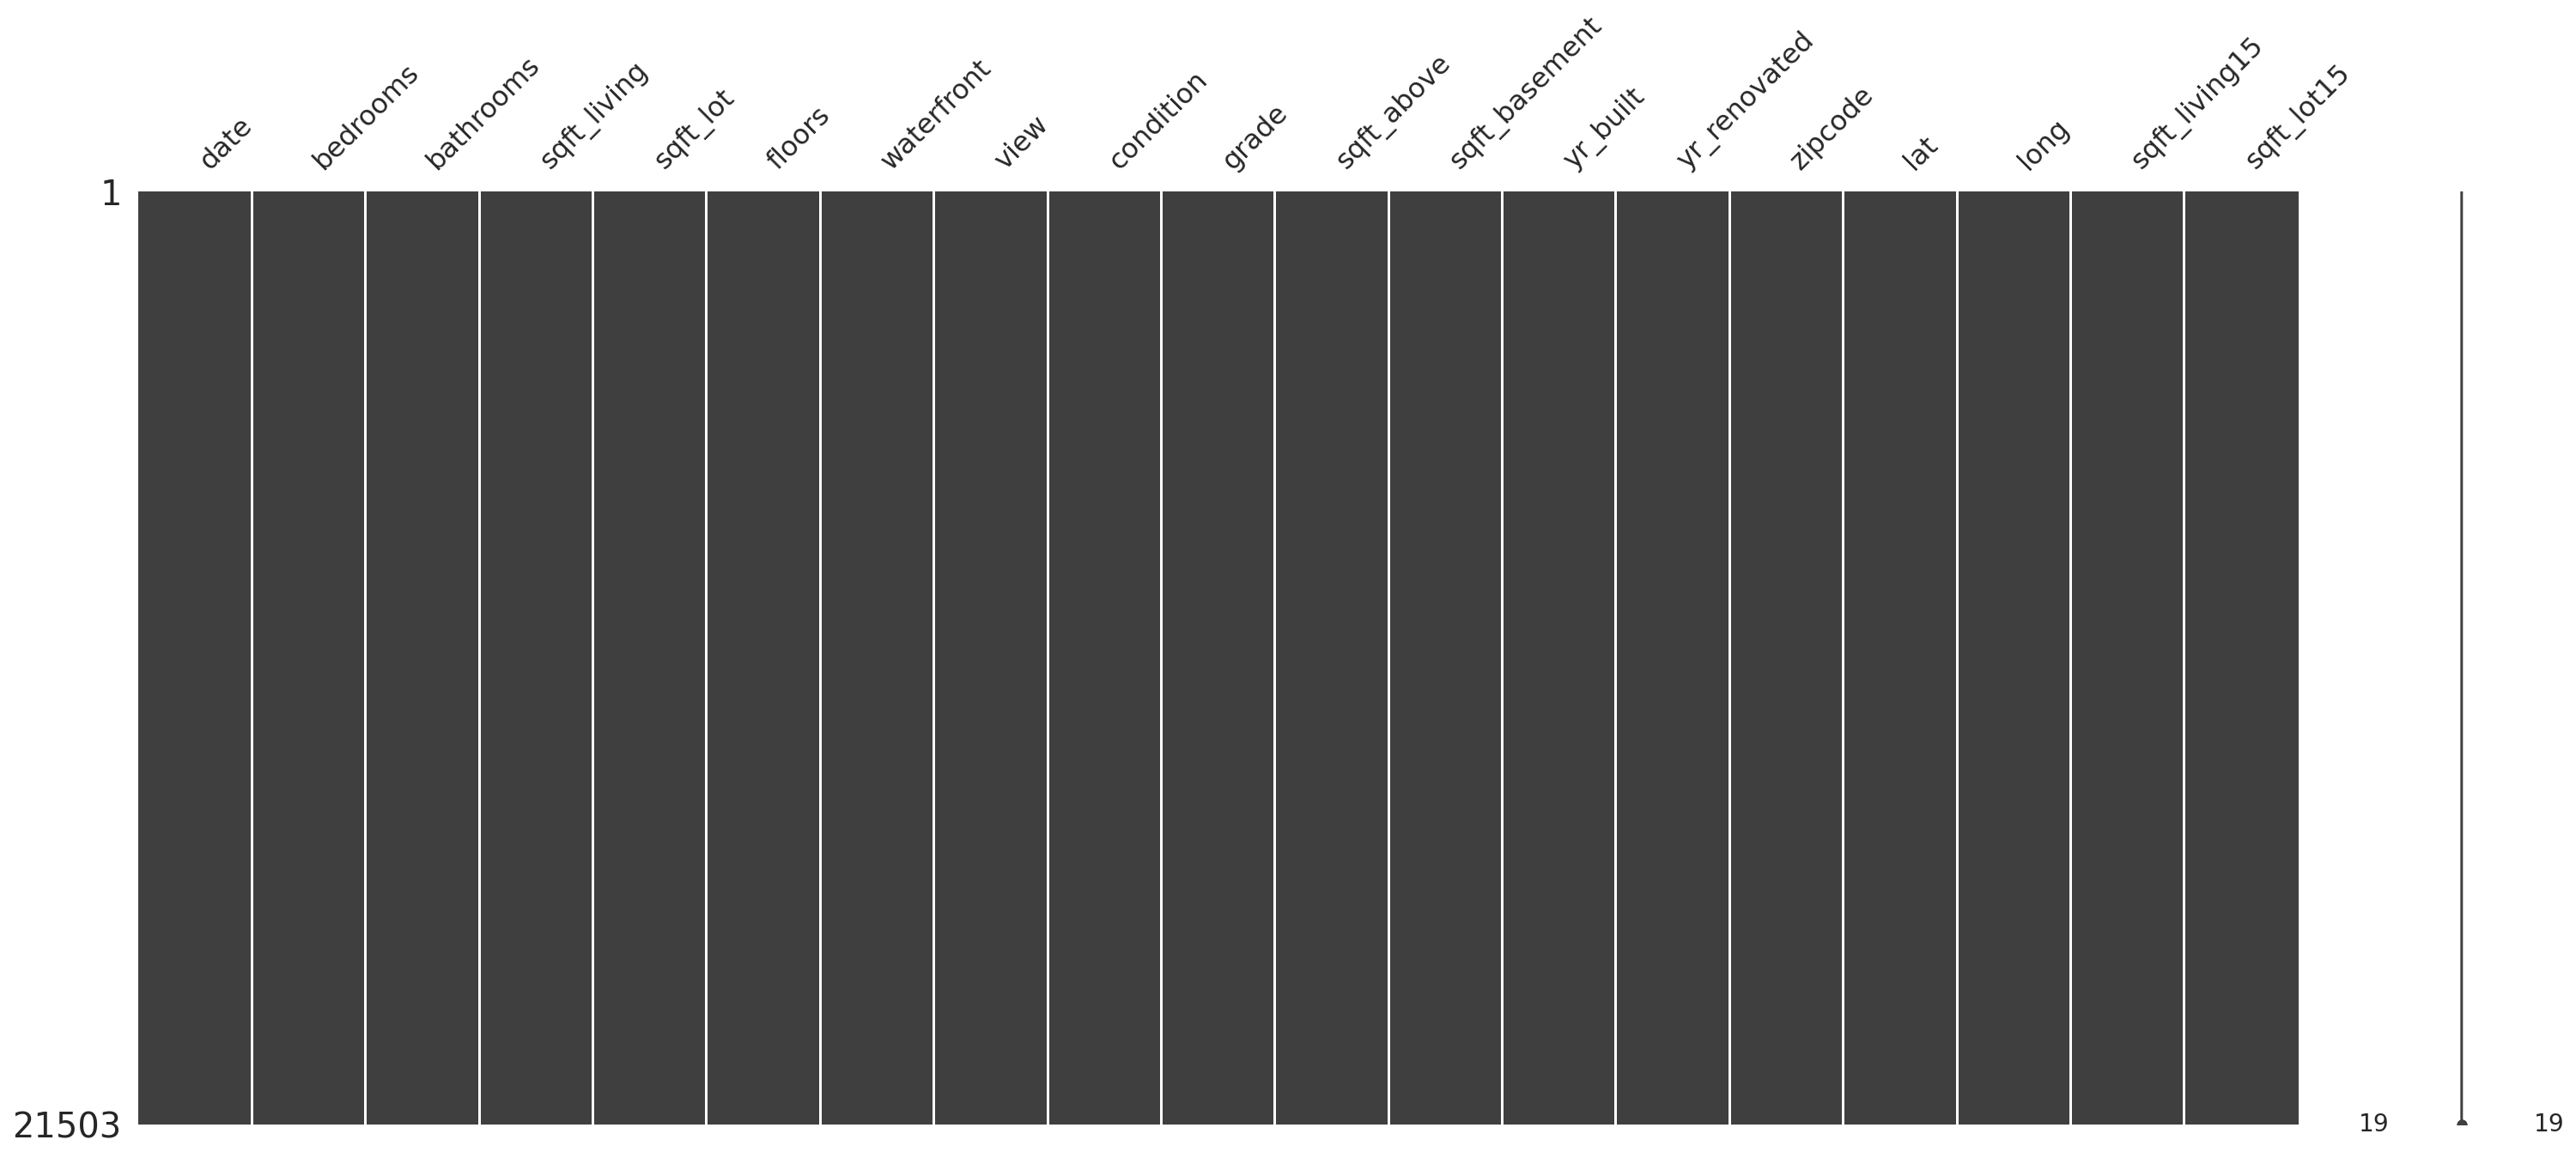

In [10]:
sum = pd.concat((train, test), axis=0)
msno.matrix(sum)

In [11]:
for c in sum.columns:
    print('{} : {}'.format(c, len(sum.loc[pd.isnull(sum[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


결측치가 없음을 확인할 수 있다.

## 로그 변환
price의 분포가 치우쳐져 있으므로 로그 변환을 통해 정규화를 한다.

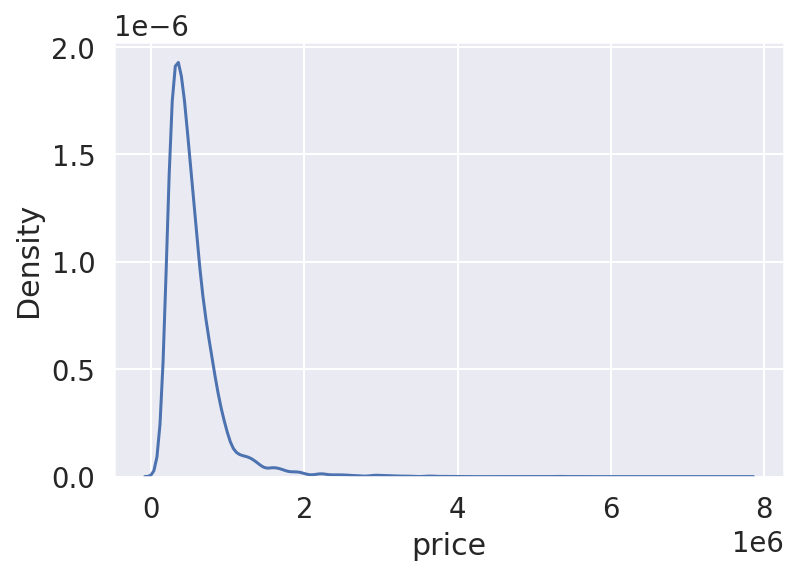

In [12]:
sns.kdeplot(y)
plt.show()

In [13]:
y=np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

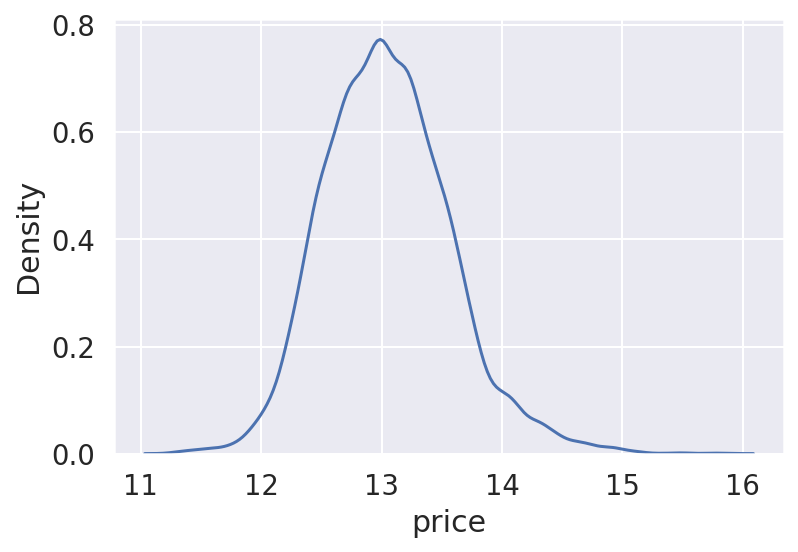

In [14]:
sns.kdeplot(y)
plt.show()

price가 정규화 된 것을 확인할 수 있다.

In [15]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

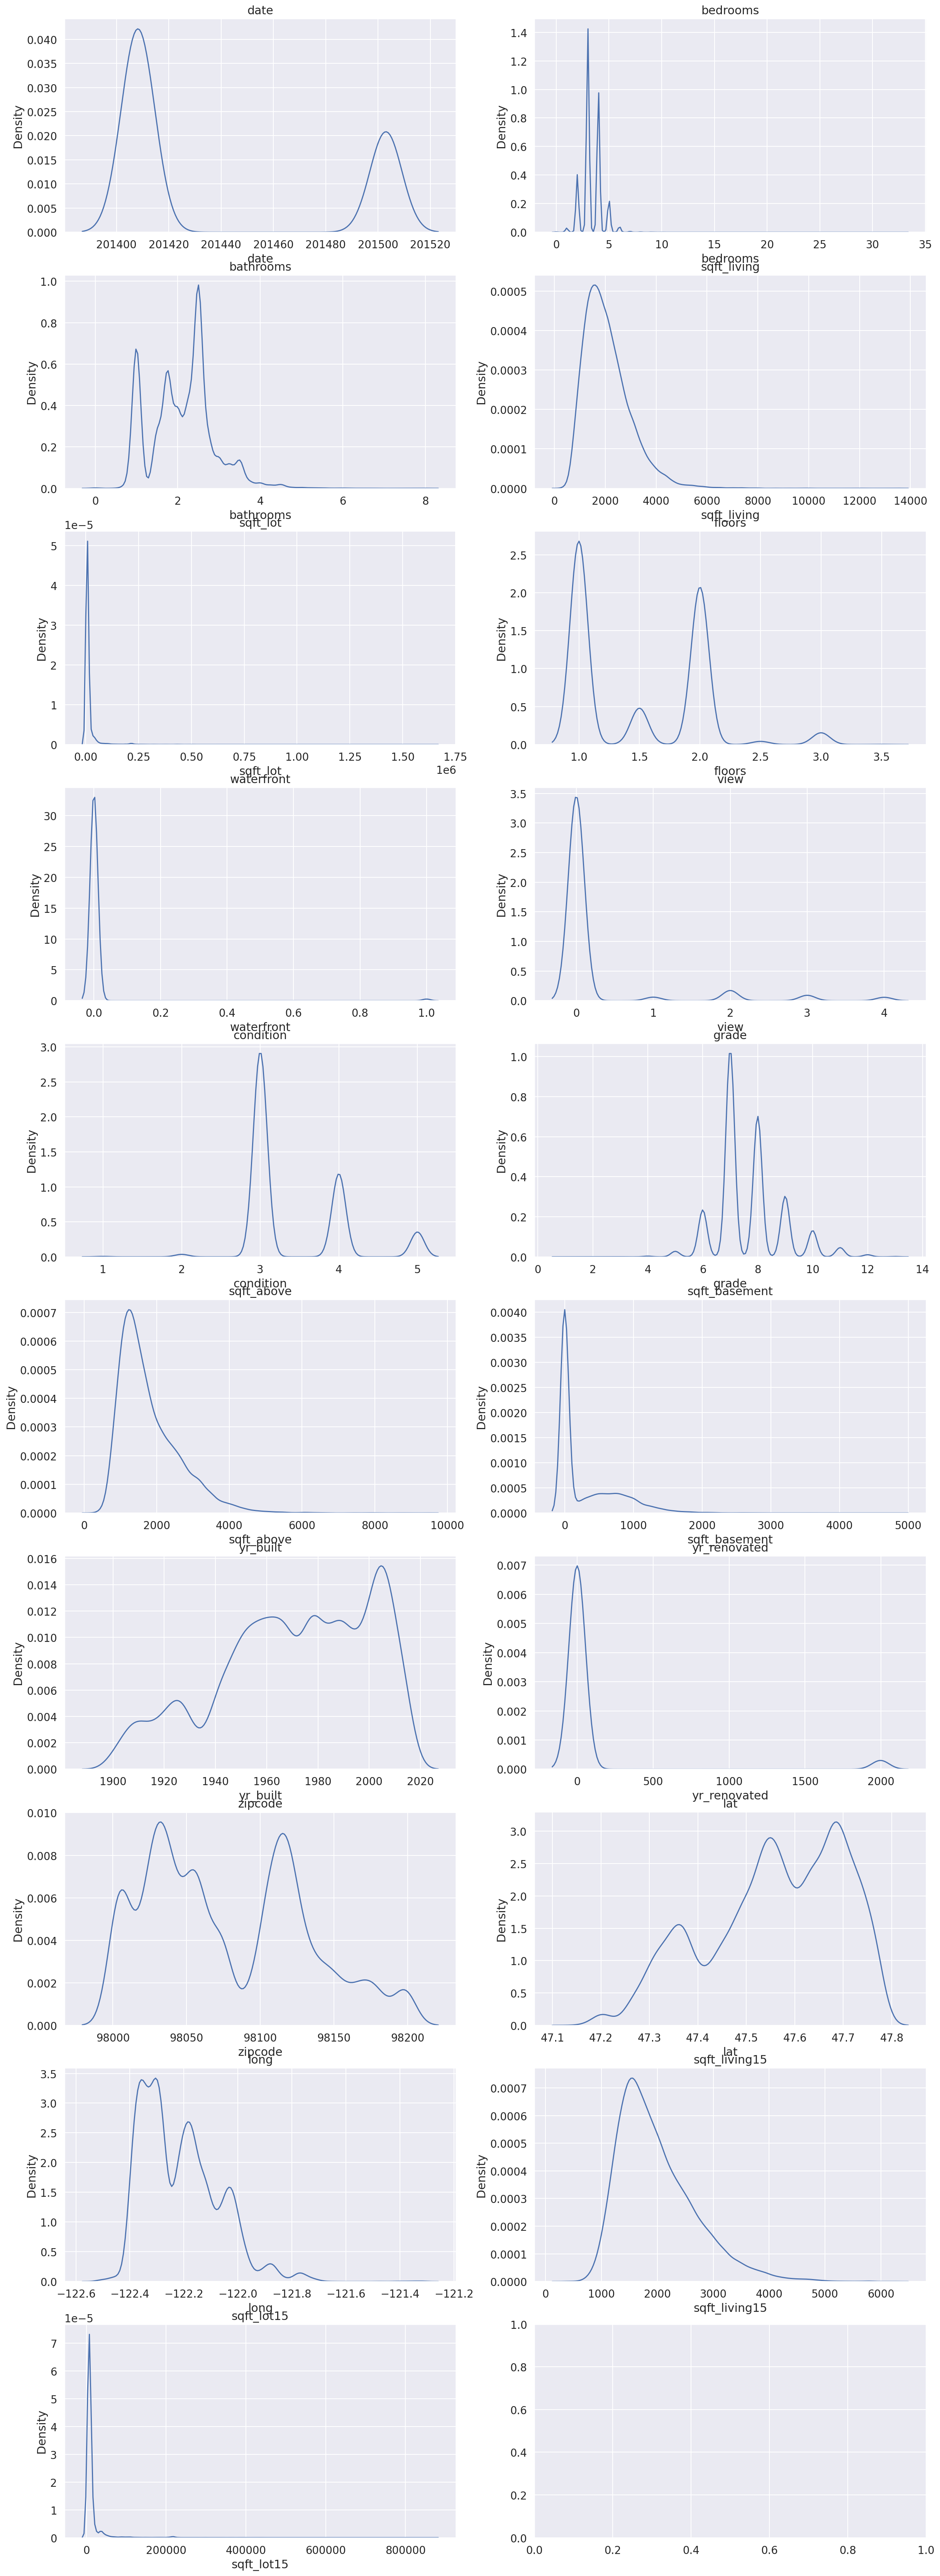

In [16]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = sum.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(sum[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우쳐져 있다.
로그 변환을 통해 정규화 하는 것이 좋아보인다.

In [17]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    sum[c] = np.log1p(sum[c].values)

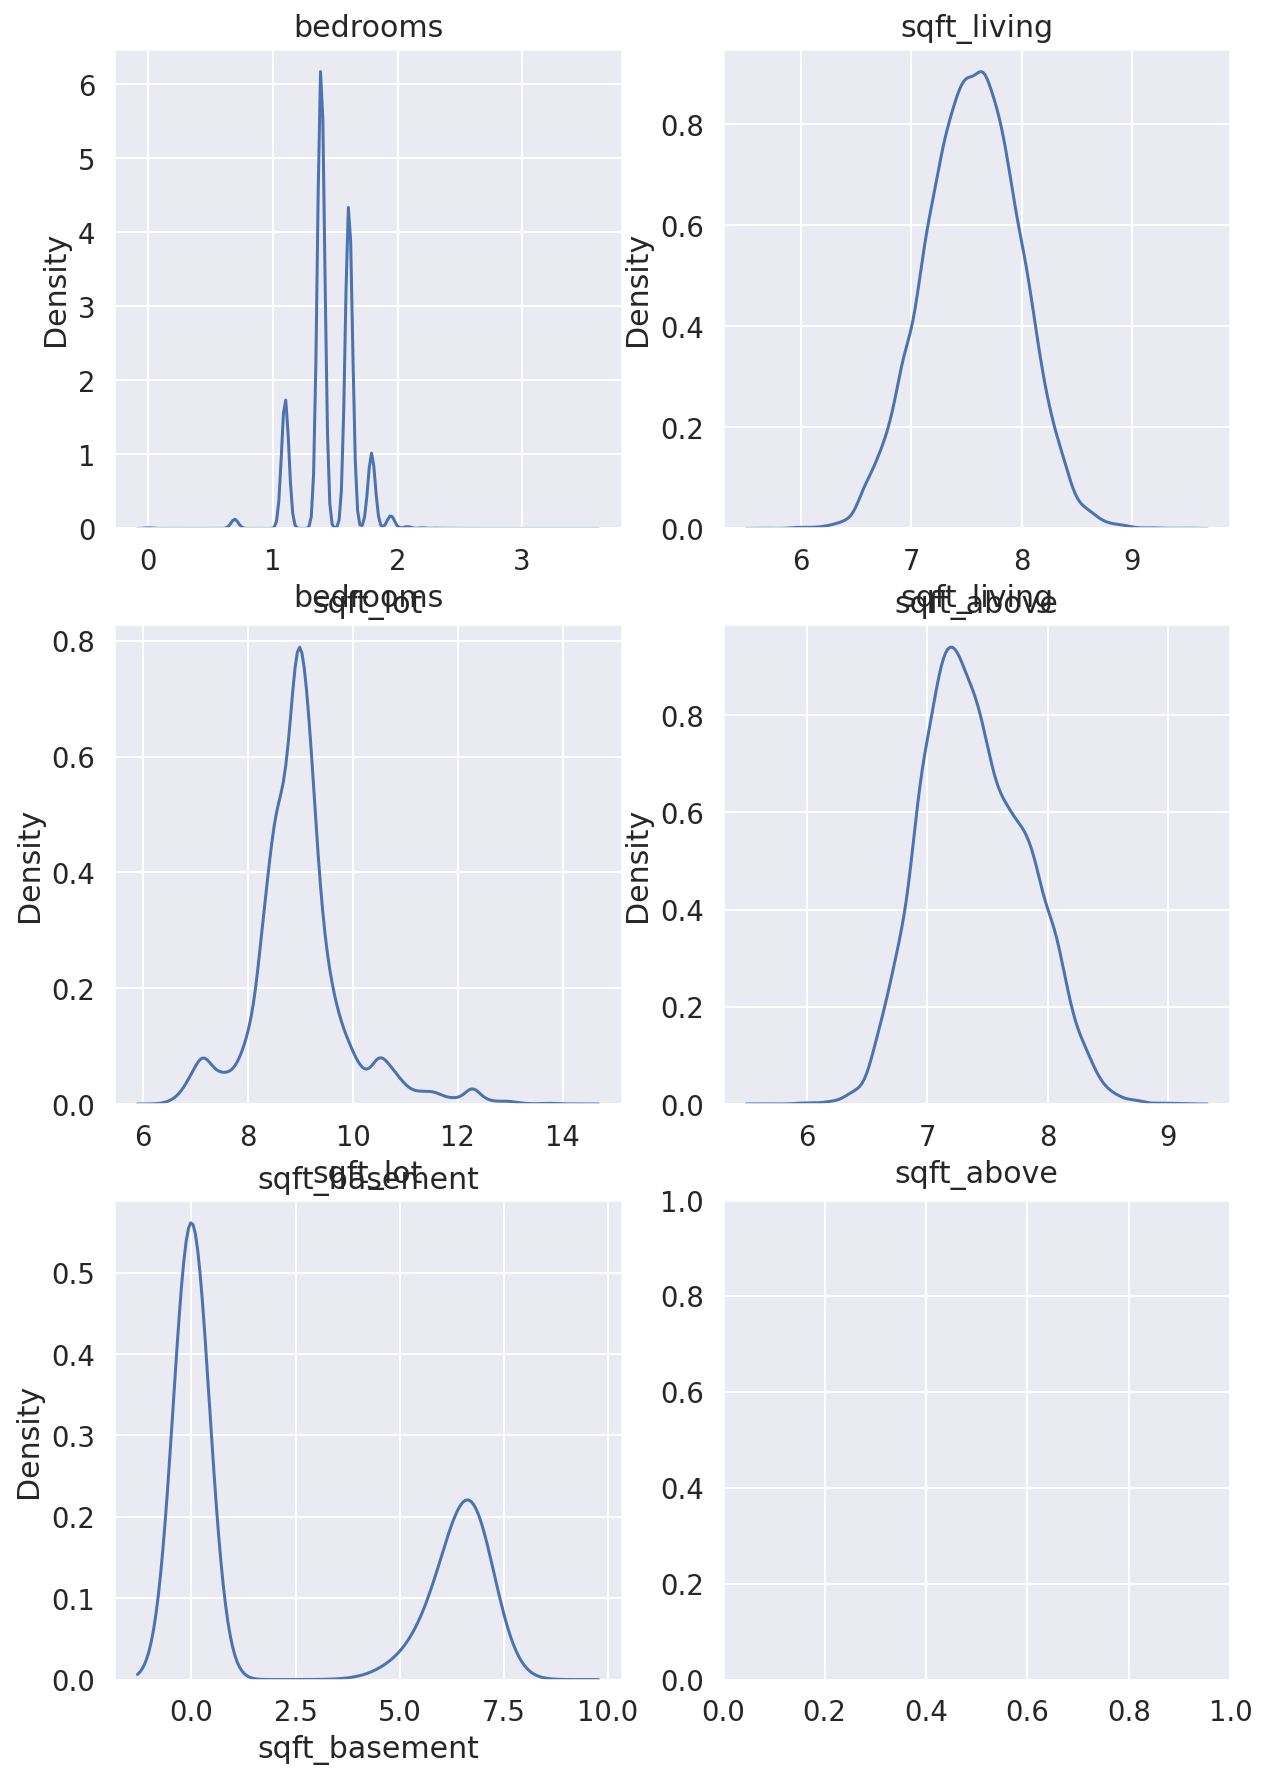

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(sum[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

어느 정도 정규화가 된 분포를 확인할 수 있다

## 새로운 피처 생성
더 잘 예측하기 위해 새로운 피처를 생성하고자 한다.

## 이상치 제거

price와 연관이 높은 5개의 변수는 grade, sqft_living, sqft_living15, sqft_above, bathrooms이었다. 

- 범주형 변수의 시각화는 boxplot
- 연속형 변수의 시각화는 scatter plot을 사용

In [19]:
df_y = y.to_frame()
df_y= df_y.rename(columns = {0:'price'})

In [20]:
print(df_y)

           price
0      12.309987
1      12.100718
2      13.142168
3      12.458779
4      12.583999
...          ...
15030  13.322338
15031  13.822984
15032  12.793862
15033  12.899222
15034  12.691584

[15035 rows x 1 columns]


1) grade

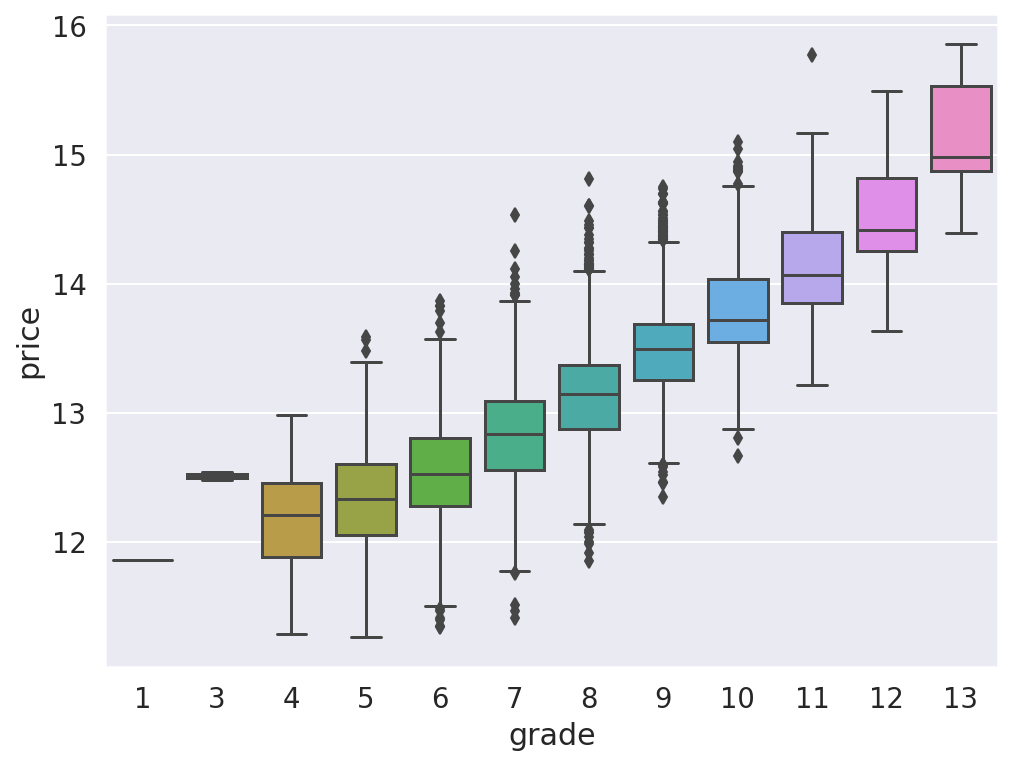

In [21]:
data=pd.concat([df_y['price'], train['grade']], axis=1)
f, ax=plt.subplots(figsize=(8,6))
fig=sns.boxplot(x='grade', y='price', data = data)

grade 7,8,11에서 위에 떨어진 이상치들이 보여서 제거하고자 한다.

In [22]:
train.loc[(data['price']>14.3) & (data['grade']==7)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,201501,4,3.25,3580,19989,1.5,1,4,4,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


grade 7에서 가장 위로 떨어진 id 12346을 이상치로 판단했다.

In [23]:
train.loc[(data['price']>14.7) & (data['grade']==8)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,201408,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


grade 8에서 가장 위로 떨어진 id 7173을 이상치로 판단했다.

In [24]:
train.loc[(data['price']>15.3) & (data['grade']==11)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,201406,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


grade 11에서 가장 위로 떨어진 id 2775을 이상치로 판단했다.

In [25]:
train.drop([12346,7173,2775])

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


2) sqft_lot(부지 평방피트)

<AxesSubplot:xlabel='sqft_lot', ylabel='Density'>

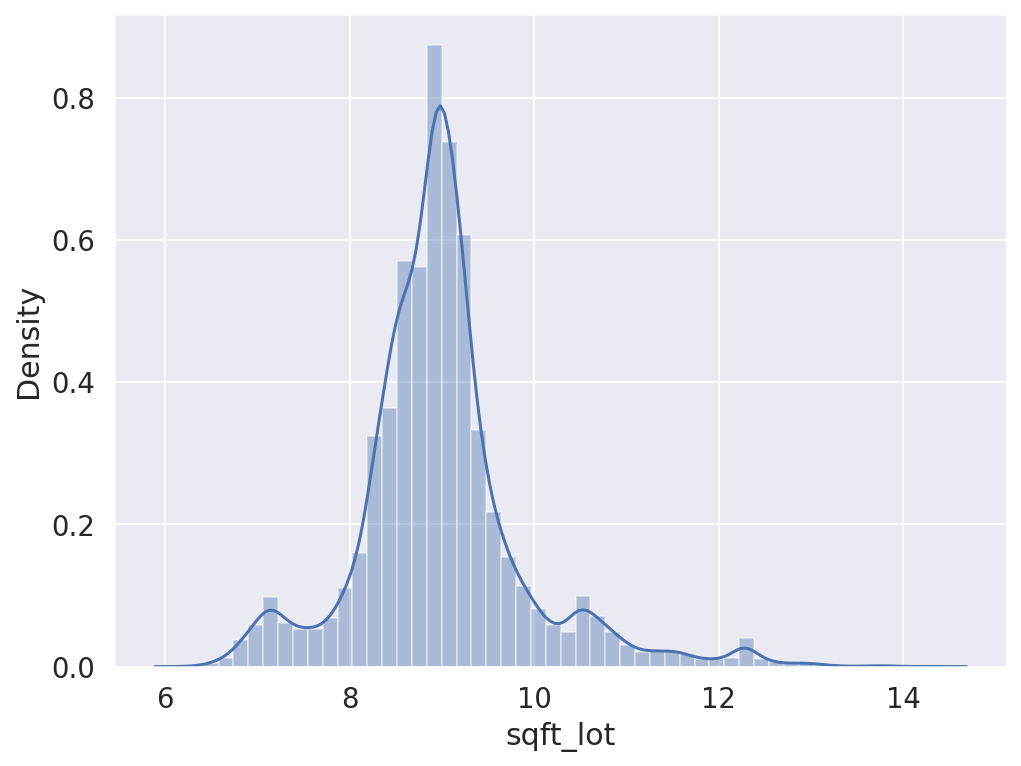

In [26]:
f, ax = plt.subplots(figsize=(8,6))
sns.distplot(sum['sqft_lot'])

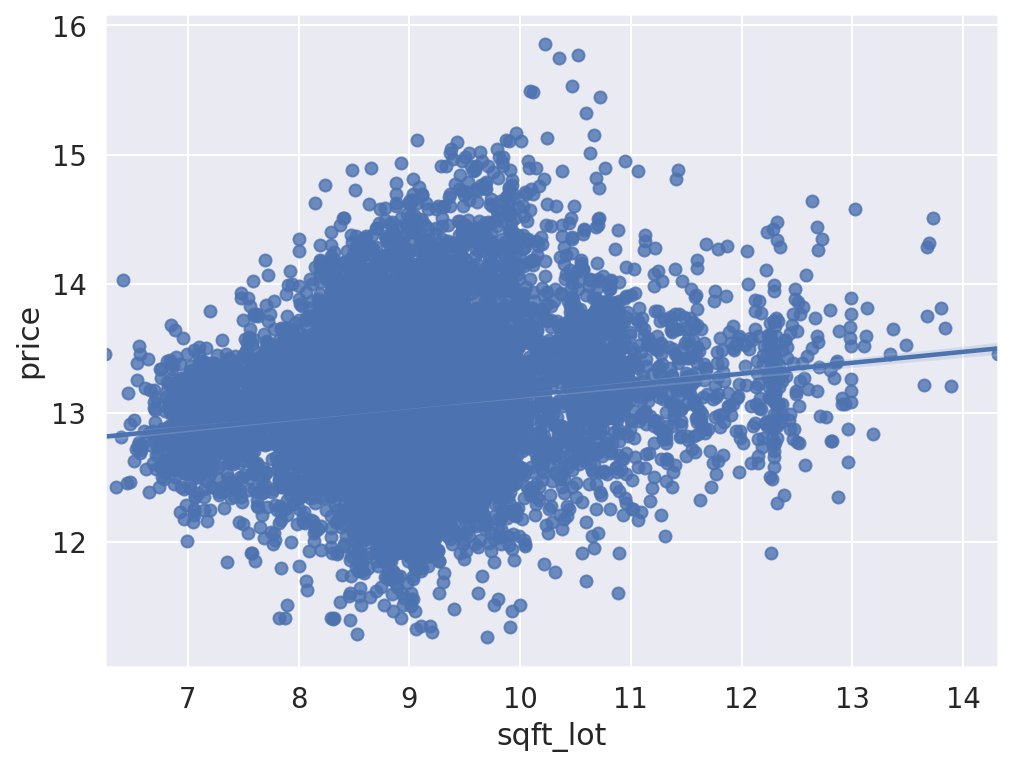

In [27]:
data = pd.concat([df_y['price'], sp.special.log1p(train['sqft_lot'])], axis = 1)
f, ax = plt.subplots(figsize = (8,6))
fig = sns.regplot(x = 'sqft_lot', y = 'price', data = data)

선에 가장 떨어져 있는 이상치는 sqft_lot 10과 11사이, price 15.6이상에 3개 있다고 판단했다.

In [28]:
train.loc[(data['price']>15.6) & (data['sqft_lot']>10)]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,201406,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
5108,201410,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,201409,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


In [29]:
train.drop([2775,5108,6469])

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


3) sqft_living15 (2015년 기준 주거 공간의 평방 피트)

<AxesSubplot:xlabel='sqft_living15', ylabel='Density'>

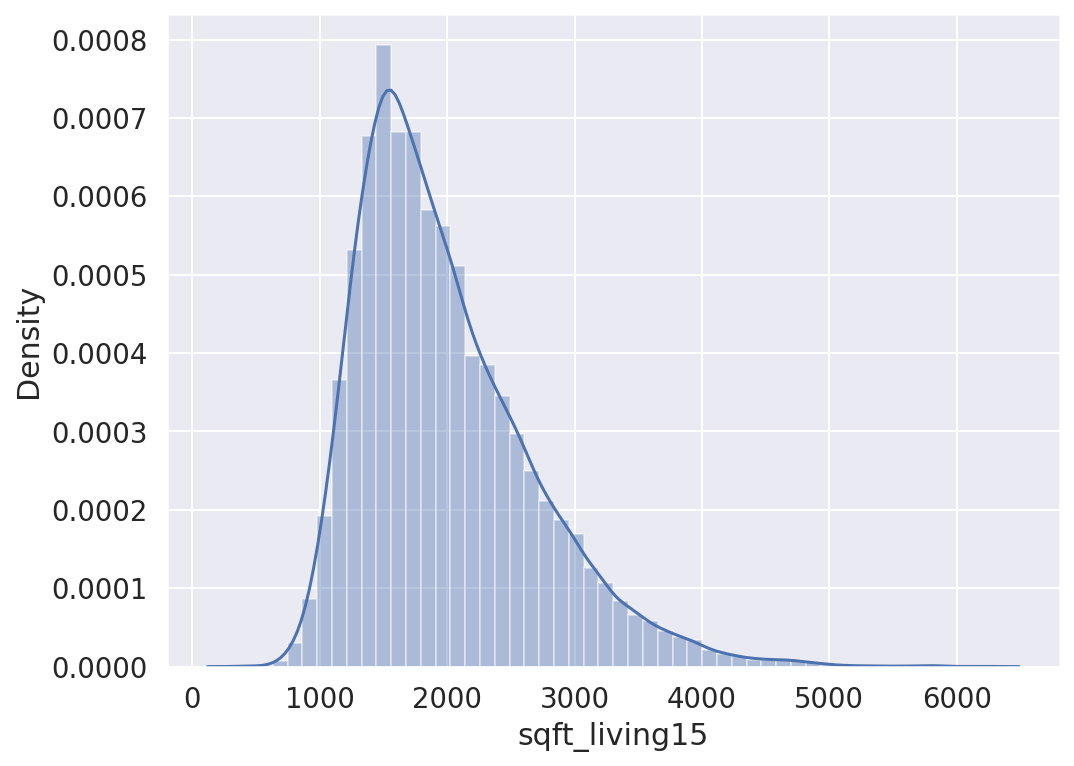

In [30]:
f, ax = plt.subplots(figsize=(8,6))
sns.distplot(sum['sqft_living15'])

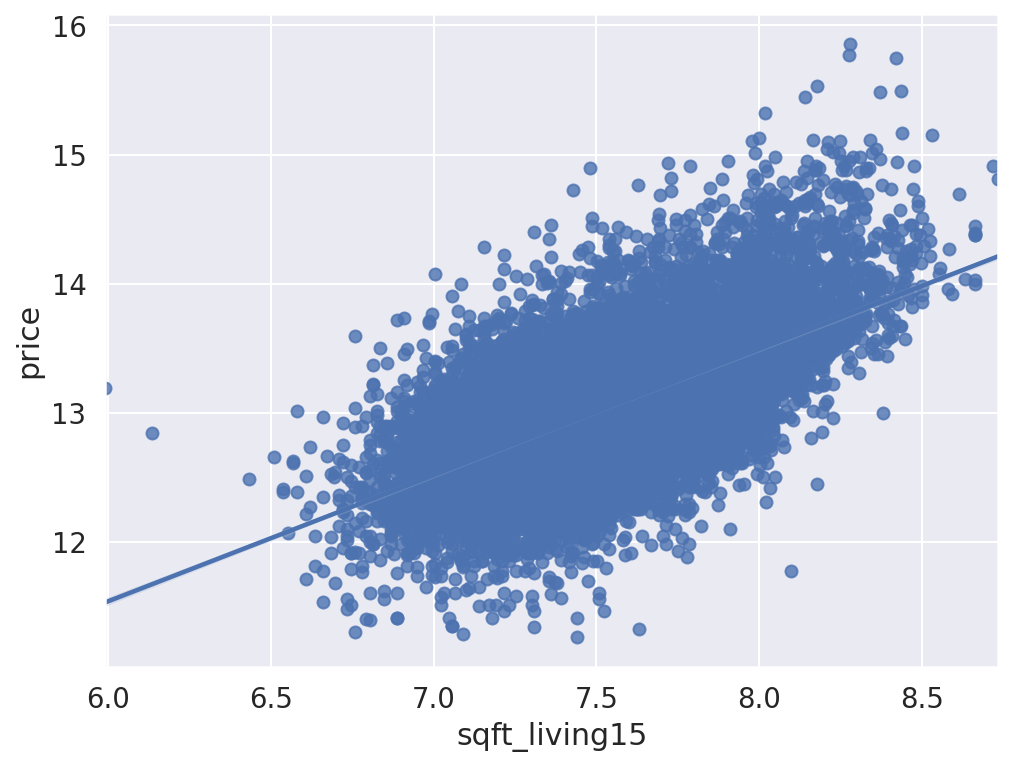

In [31]:
data = pd.concat([df_y['price'], sp.special.log1p(train['sqft_living15'])], axis = 1)
f, ax = plt.subplots(figsize = (8,6))
fig = sns.regplot(x = 'sqft_living15', y = 'price', data = data)

sqft_living15 6.5와 8.5사이에 대부분 분포되어 있는데에 반해 6.4 이하에 있는 2개의 데이터를 이상치로 판단했다.

In [32]:
train.loc[data['sqft_living15']<6.4]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9372,201505,3,2.75,2290,34548,2.0,0,3,4,7,2290,0,1984,0,98042,47.3691,-122.163,399,275299
12007,201406,5,2.50,2760,8015,1.0,0,0,4,8,1600,1160,1960,0,98125,47.7255,-122.297,460,18000


In [33]:
train.drop([9372,12007])

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


4) sqft_above (지하실을 제외한 평방 피트)

<AxesSubplot:xlabel='sqft_above', ylabel='Density'>

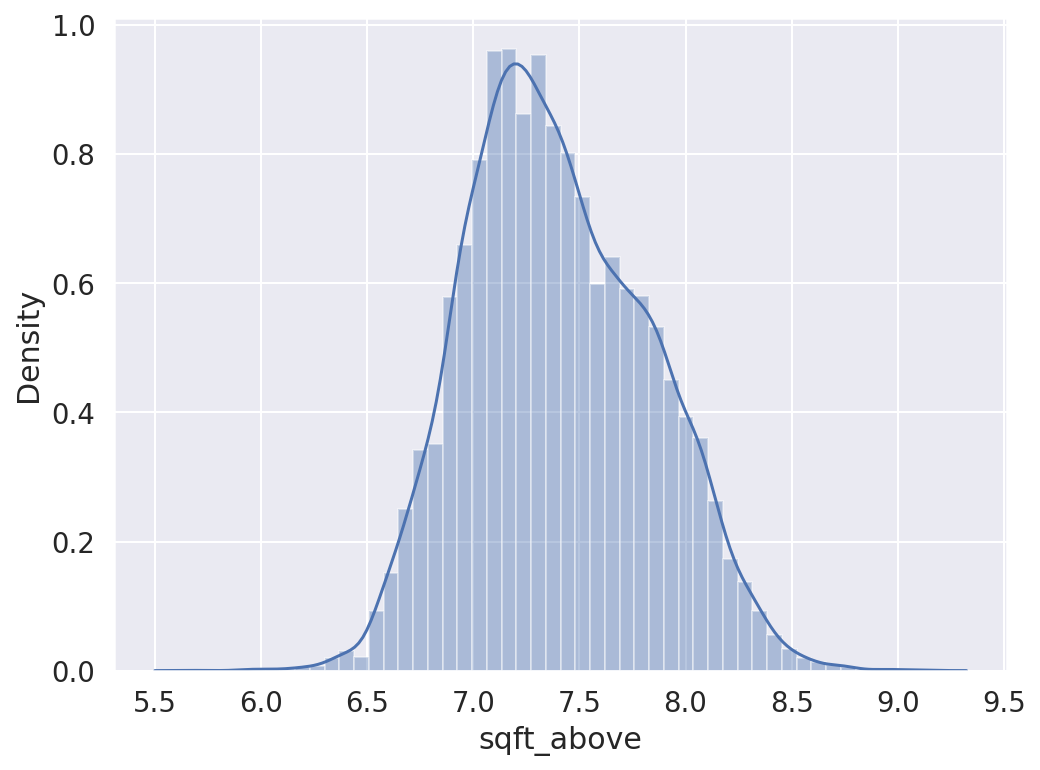

In [34]:
f, ax = plt.subplots(figsize=(8,6))
sns.distplot(sum['sqft_above'])

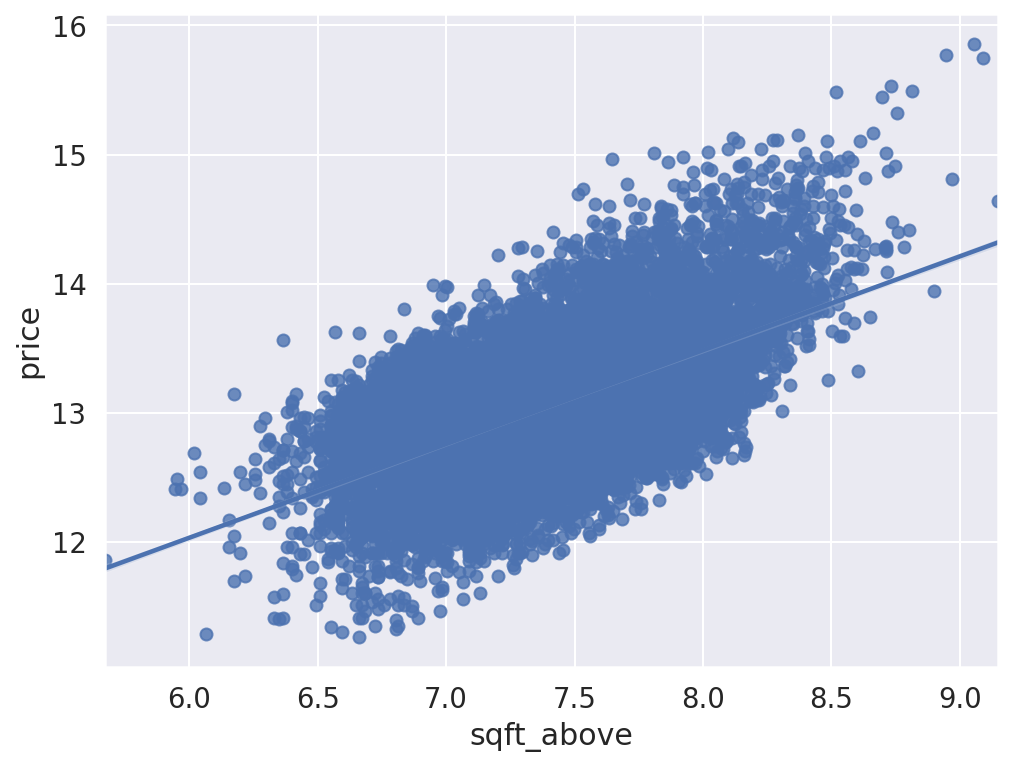

In [35]:
data = pd.concat([df_y['price'], sp.special.log1p(train['sqft_above'])], axis = 1)
f, ax = plt.subplots(figsize = (8,6))
fig = sns.regplot(x = 'sqft_above', y = 'price', data = data)

특별한 이상치가 보이지 않아서 제거하지 않았다.

5) bathrooms

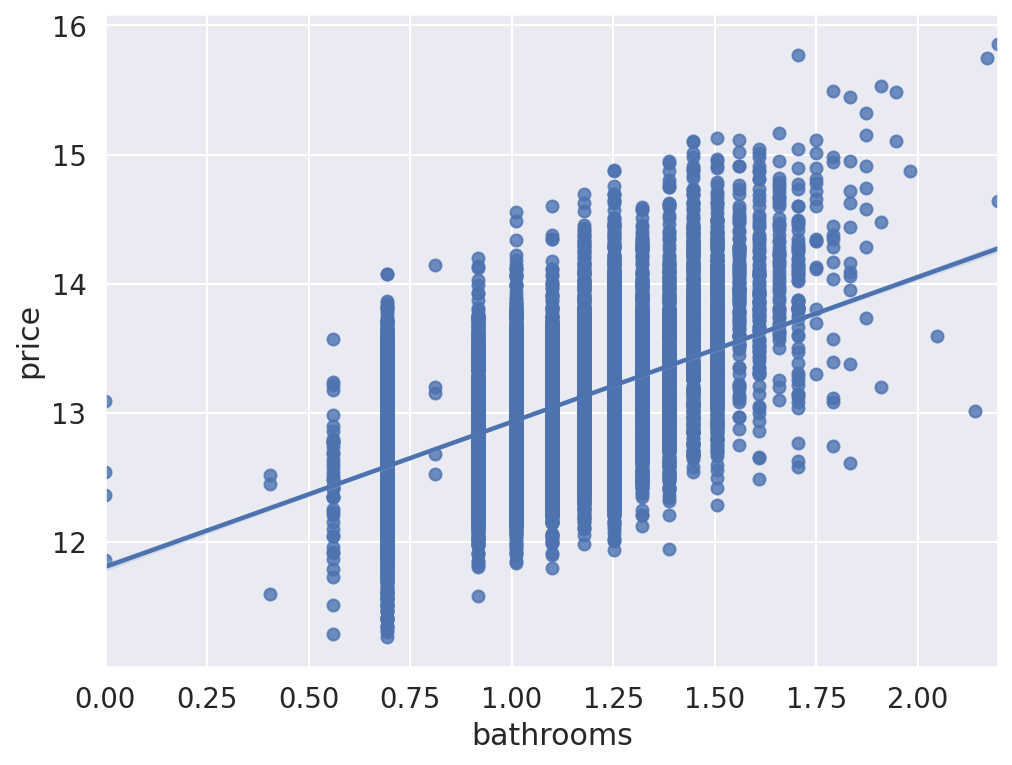

In [36]:
data = pd.concat([df_y['price'], sp.special.log1p(train['bathrooms'])], axis = 1)
f, ax=plt.subplots(figsize=(8,6))
fig = sns.regplot(x = 'bathrooms', y = 'price', data = data)

In [37]:
train.loc[data['bathrooms']==0]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4123,201411,1,0.0,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549
6885,201412,0,0.0,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
7322,201409,1,0.0,690,23244,1.0,0,0,4,7,690,0,1948,0,98053,47.6429,-121.955,1690,19290
13522,201409,0,0.0,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850


In [38]:
train.drop([6885,13522])

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


화장실이 없는 방 중에 bedrooms도 없는 방은 삭제해줬다.

## 3. 모델링

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [83]:
# 결과가 log변환 되어있으므로 그것을 다시 바꿔주는 연산도 포함
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [167]:
random_state=42        

gboost = GradientBoostingRegressor(learning_rate=0.015, n_estimators=1500,random_state=random_state)
xgboost = XGBRegressor(n_estimators=1000,max_depth=10, random_state=random_state)
lightgbm = LGBMRegressor(n_estimators=350,max_depth=10, random_state=random_state)
lightgbm_1 = LGBMRegressor(n_estimators=400,max_depth=10, random_state=random_state)
lightgbm_2 = LGBMRegressor(n_estimators=300,max_depth=10, random_state=random_state)
lightgbm_3 = LGBMRegressor(n_estimators=450,max_depth=10, random_state=random_state)
lightgbm_4 = LGBMRegressor(n_estimators=300,max_depth=12, random_state=random_state)
lightgbm_5 = LGBMRegressor(n_estimators=350,max_depth=12, random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
vot = VotingRegressor(estimators=[('xgb', xgboost), ('lgbm', lightgbm), ('lgbm1', lightgbm_1), ('lgbm2', lightgbm_2), ('lgbm3', lightgbm_3)])

models = [gboost, xgboost, lightgbm, rdforest, vot]

In [146]:
# 클래스 이름 
gboost.__class__.__name__

'GradientBoostingRegressor'

In [135]:
def get_scores(models, train, y):
    
    df={}
    
    for model in models:
        model_name=model.__class__.__name__
        
        X_train,X_test,y_train,y_test=train_test_split(train,y,random_state=random_state,test_size=0.2)
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        
        df[model_name]=rmse(y_test,y_pred)
        score_df=pd.DataFrame(df,index=['RMSE']).T.sort_values('RMSE',ascending=False)
        
    return score_df

get_scores(models, train, y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,RMSE
RandomForestRegressor,141074.076029
XGBRegressor,126885.154514
GradientBoostingRegressor,125225.191997
LGBMRegressor,119088.920943
VotingRegressor,117863.292248


In [136]:
# 그리드 파라미터 설정
param_grid={
    #'boosting' : ['goss'],
    'n_estimators':[300,350,400,450],
    'max_depth':[6,8,10,12],
    #'learning late':[0.001, 0.01, 0.05],
    #'min_samples_split':[0.005, 0.01, 0.1],
    #'max_features': ['sqrt','auto'],
}

In [137]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [138]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   38.2s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,n_estimators,score,RMSLE
9,10,350,-0.026110,0.161587
10,10,400,-0.026121,0.161619
8,10,300,-0.026127,0.161640
11,10,450,-0.026176,0.161791
12,12,300,-0.026178,0.161796
13,12,350,-0.026203,0.161874
14,12,400,-0.026205,0.161879
15,12,450,-0.026251,0.162021
5,8,350,-0.026323,0.162243
1,6,350,-0.026339,0.162292


In [168]:
model = VotingRegressor(estimators=[('xgb', xgboost),('lgbm', lightgbm), ('lgbm1', lightgbm_1), ('lgbm2', lightgbm_2), ('lgbm3', lightgbm_3), ('lgbm4', lightgbm_4), ('lgbm5', lightgbm_5)])
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.15436637, 13.07746606, 14.07866212, ..., 13.06404603,
       12.69837136, 13.00241357])

In [169]:
prediction = np.expm1(prediction)
prediction

array([ 516259.29623879,  478046.82582199, 1301022.89476235, ...,
        471674.26681831,  327213.55194735,  443481.477658  ])

In [170]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [171]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.162593e+05
1,15036,4.780468e+05
2,15037,1.301023e+06
3,15038,2.928281e+05
4,15039,3.317096e+05


# 4. 저장하기

In [172]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [173]:
save_submission(model, train, y, test, 'voting', rmsle='0.161587_7')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_voting_RMSLE_0.161587_7.csv saved!


# 회고

- 어떤 기준으로 private 점수가 낮게 나오는지 모르겠다.
- rmsle가 무조건 낮게 나온다고 좋은 건 아닌 것 같다.
- randomforest와 voting 방식을 했을 때 오히려 낮은 점수가 나와서 당황스러웠다.
- 계속 파라미터를 바꿨는데, 어떤 기준으로 점수가 좋게 나오는지 감을 못잡겠다.
- 과적합이 관건인 것 같은데 아직 잘 모르겠다.

- voting에서 모델 수를 늘리니깐 private 점수가 낮게 나왔다.

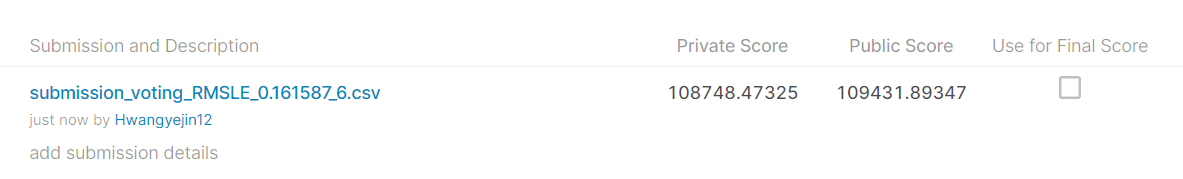